In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns



from sklearn.metrics import r2_score
from datetime import datetime

In [2]:
!pip install -U statsmodels


from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.statespace.varmax import VARMAX
from statsmodels.tsa.api import VAR
from sklearn.preprocessing import StandardScaler

In [3]:
df = pd.read_csv('/content/temperature.csv')

In [4]:
df.head()

,record_id,month,day,year,AverageTemperatureFahr,AverageTemperatureUncertaintyFahr,City,country_id,Country,Latitude,Longitude
0,474376,1,1,1853,NaN,NaN,Auckland,NEW,New Zealand,36.17S,175.03E
1,474377,2,1,1853,NaN,NaN,Auckland,NEW,New Zealand,36.17S,175.03E
2,474378,3,1,1853,NaN,NaN,Auckland,NEW,New Zealand,36.17S,175.03E
3,474379,4,1,1853,NaN,NaN,Auckland,NEW,New Zealand,36.17S,175.03E
4,474380,5,1,1853,NaN,NaN,Auckland,NEW,New Zealand,36.17S,175.03E


In [5]:
def parse_date(row):
  s = f"{row['year']}-{row['month']}-{row['day']}"
  return datetime.strptime(s, "%Y-%m-%d")

In [6]:
df['Date'] = df.apply(parse_date, axis = 1)

In [7]:
df['City'].value_counts()

Odesa           3214
Paris           3210
Kherson         3209
Kiev            3208
Wroclaw         3208
Stockholm       3207
Lvov            3207
Warsaw          3203
Marseille       3202
Uppsala         3201
Canoas          2157
Brasília        2156
Tottori         2056
Tokyo           2001
Hamilton        1914
Auckland        1912
Cape Town       1866
Johannesburg    1855
Name: City, dtype: int64

In [8]:
Tokyo = df[df['City'] == 'Tokyo'].copy().dropna()
Cape_Town = df[df['City'] == 'Cape Town'].copy().dropna()

In [9]:
Tokyo = Tokyo[['Date', 'AverageTemperatureFahr']].copy()
Cape_Town = Cape_Town[['Date', 'AverageTemperatureFahr']].copy()

In [10]:
Tokyo.set_index(Tokyo['Date'], inplace = True)
Tokyo.drop('Date', axis = 1, inplace = True)
Tokyo.columns = ['TokyoTemp']

In [11]:
Tokyo.head()

,TokyoTemp
Date,
1845-01-01,36.2786
1845-02-01,34.3616
1845-03-01,41.4968
1845-04-01,50.6966
1845-05-01,58.8614


In [12]:
Cape_Town.set_index(Cape_Town['Date'], inplace = True)
Cape_Town.drop('Date', axis = 1, inplace = True)
Cape_Town.columns = ['CapeTownTemp']

In [13]:
Cape_Town.head()

,CapeTownTemp
Date,
1857-01-01,65.2190
1857-02-01,67.5698
1857-03-01,64.3172
1857-04-01,58.6220
1857-05-01,56.6960


In [14]:
joined_df = Cape_Town.join(Tokyo, how = 'outer')

In [15]:
joined_df.shape

(2021, 2)

In [16]:
joined_part = joined_df.iloc[-500:].copy()
joined_part.index_freq = 'MS'

In [17]:
joined_part.isna().sum()

CapeTownTemp    7
TokyoTemp       4
dtype: int64

In [18]:
joined_part.interpolate(inplace = True)

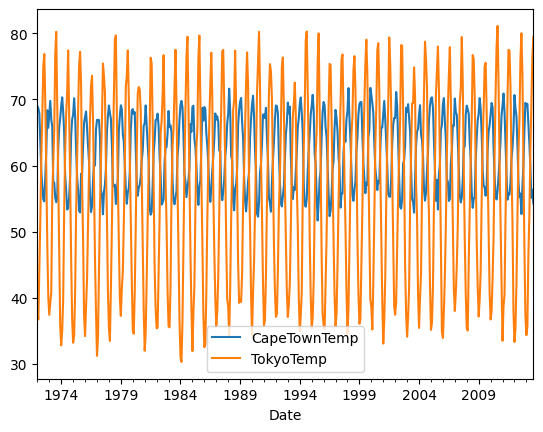

In [19]:
joined_part.plot();

In [20]:
Ntest = 30
train = joined_part.iloc[:-30].copy()
test = joined_part.iloc[-Ntest:].copy()

In [21]:
train_idx = joined_part.index <= train.index[-1]
test_idx = joined_part.index > train.index[-1]

In [22]:
scaler = StandardScaler()

train['scaled_Tokyo'] = scaler.fit_transform(train[['TokyoTemp']])

test['scaled_Tokyo'] = scaler.transform(test[['TokyoTemp']])


In [23]:
train['scaled_Cape_Town'] = scaler.fit_transform(train[['CapeTownTemp']])

test['scaled_Cape_Town'] = scaler.transform(test[['CapeTownTemp']])


In [24]:
joined_part.loc[train_idx, 'scaled_Tokyo'] = train['scaled_Tokyo']
joined_part.loc[test_idx, 'scaled_Tokyo'] = test['scaled_Tokyo']
joined_part.loc[train_idx, 'scaled_Cape_Town'] = train['scaled_Cape_Town']
joined_part.loc[test_idx, 'scaled_Cape_Town'] = test['scaled_Cape_Town']

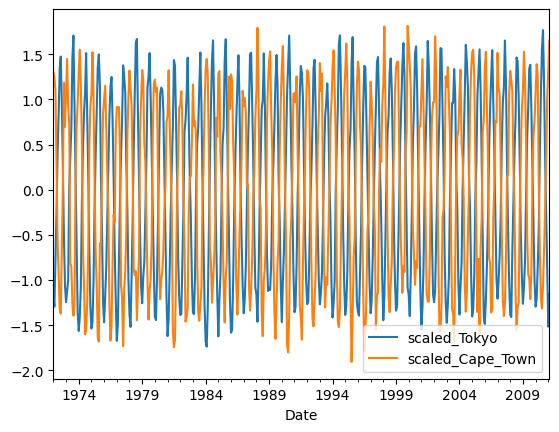

In [25]:
cols = ['scaled_Tokyo', 'scaled_Cape_Town']
train[cols].plot();

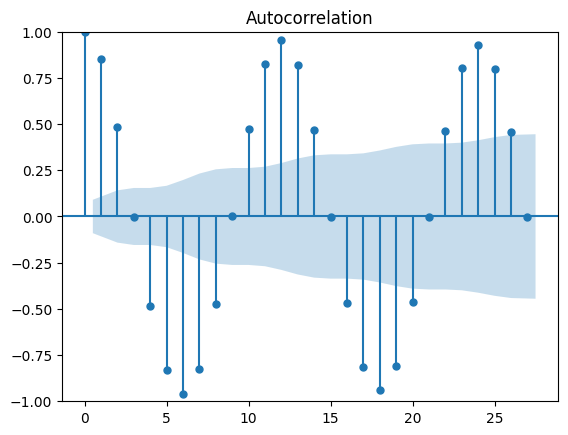

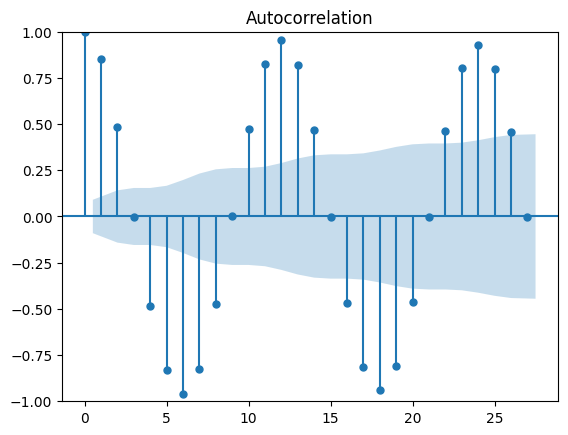

In [26]:
plot_acf(train['scaled_Tokyo'])

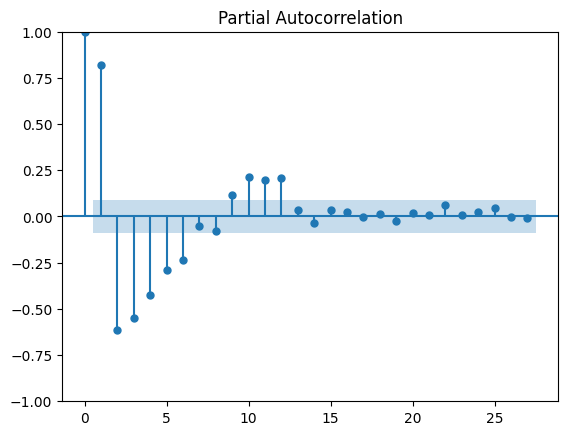

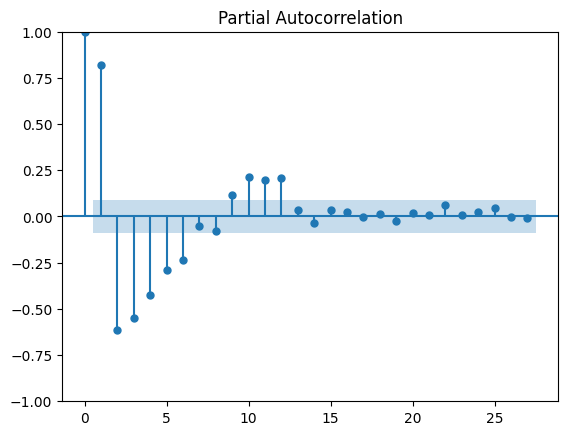

In [27]:
plot_pacf(train['scaled_Cape_Town'])

In [28]:
t0 = datetime.now()

model = VARMAX(train[cols], order = (10, 10))
res = model.fit(maxiter = 100)
print("Duration : ", datetime.now() - t0)

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/varmax.py:161: EstimationWarning: Estimation of VARMA(p,q) models is not generically robust, due especially to identification issues.
  warn('Estimation of VARMA(p,q) models is not generically robust,'
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Duration :  0:02:34.334367


In [29]:
fcast = res.get_forecast(Ntest)

In [30]:
res.fittedvalues['scaled_Tokyo']

Date
1972-01-01    0.005406
1972-02-01   -1.013977
1972-03-01   -1.000524
1972-04-01   -0.285447
1972-05-01    0.328190
                ...   
2010-10-01    0.371757
2010-11-01   -0.422183
2010-12-01   -1.024362
2011-01-01   -1.237000
2011-02-01   -1.247485
Name: scaled_Tokyo, Length: 470, dtype: float64

In [31]:
joined_part.loc[train_idx,'Train_pred_Tokyo'] = res.fittedvalues['scaled_Tokyo']
joined_part.loc[test_idx, 'Test_pred_Tokyo'] = fcast.predicted_mean['scaled_Tokyo']



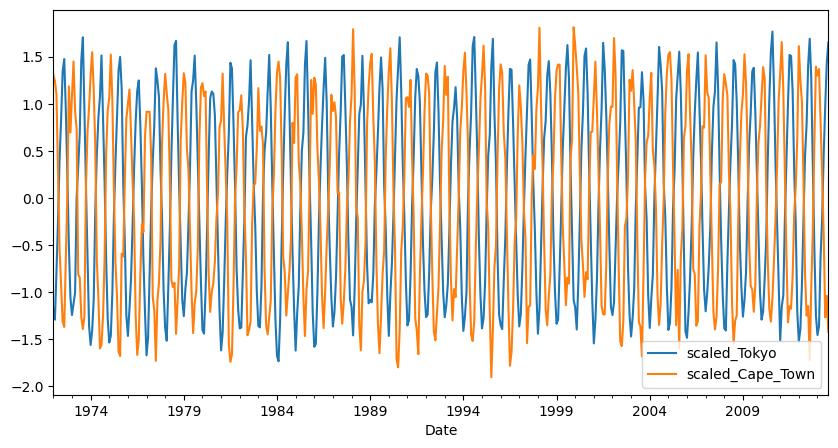

In [32]:
plot_cols = ['scaled_Tokyo', 'Train_pred_Tokyo', 'Test_pred_Tokyo']
joined_part.iloc[-500:][cols].plot(figsize = (10, 5));

In [33]:
joined_part.loc[train_idx,'Train_pred_Cape_Town'] = res.fittedvalues['scaled_Cape_Town']
joined_part.loc[test_idx, 'Test_pred_Cape_Town'] = fcast.predicted_mean['scaled_Cape_Town']

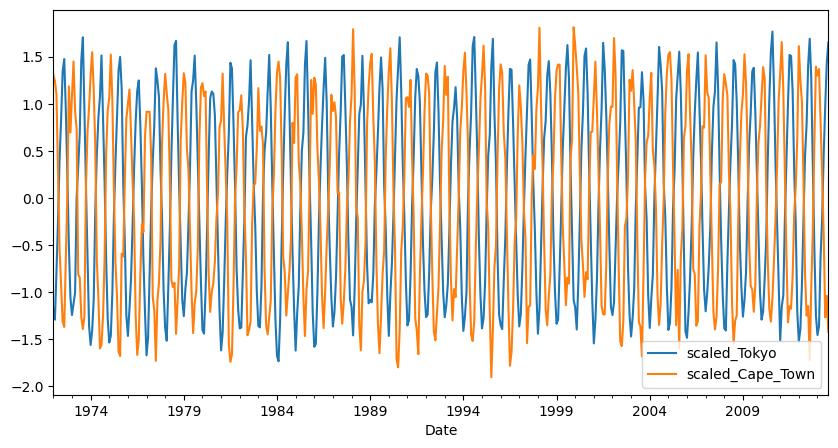

In [34]:
plot_cols = ['scaled_Cape_Town', 'Train_pred_Cape_Town', 'Test_pred_Cape_Town']
joined_part.iloc[-500:][cols].plot(figsize = (10, 5));

In [37]:
y_pred = joined_part.loc[train_idx, 'Train_pred_Tokyo']
y_true = joined_part.loc[train_idx, 'scaled_Tokyo']
print(' Tokyo Train R2 : ', r2_score(y_true, y_pred))


y_pred = joined_part.loc[test_idx, 'Test_pred_Tokyo']
y_true = joined_part.loc[test_idx, 'scaled_Tokyo']
print(' Tokyo Test R2 : ', r2_score(y_true, y_pred))

 Tokyo Train R2 :  0.978449724372537
 Tokyo Test R2 :  0.9830302895459406


In [38]:
y_pred = joined_part.loc[train_idx, 'Train_pred_Cape_Town']
y_true = joined_part.loc[train_idx, 'scaled_Cape_Town']
print('Cape Town Train R2 : ', r2_score(y_true, y_pred))


y_pred = joined_part.loc[test_idx, 'Test_pred_Cape_Town']
y_true = joined_part.loc[test_idx, 'scaled_Cape_Town']
print('Cape Town Test R2 : ', r2_score(y_true, y_pred))

Cape Town Train R2 :  0.9363039080148325
Cape Town Test R2 :  0.9525407926986449
